# 1.필요한 라이브러리 import

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


# 2. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# 3. 전처리

+ 결측치 확인

<AxesSubplot:>

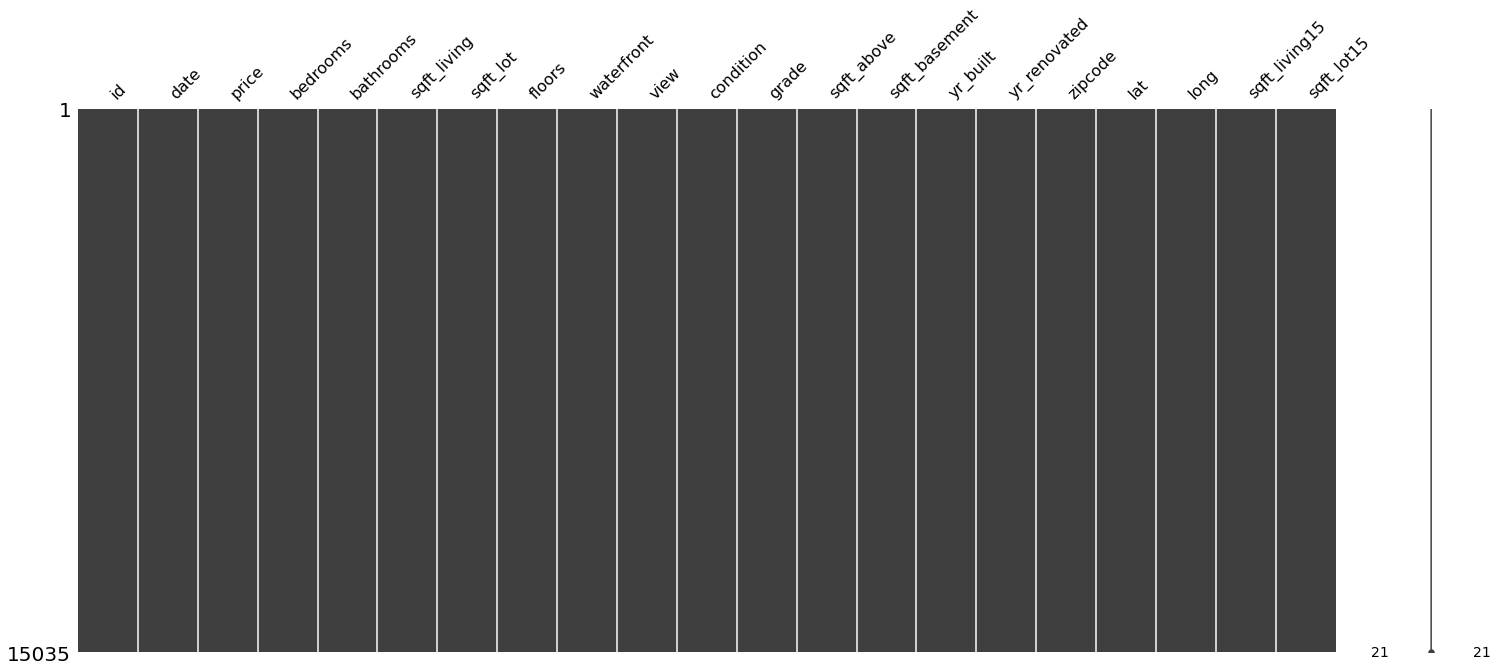

In [5]:
msno.matrix(train)

In [6]:
for c in train.columns:
    print('{} : {}'.format(c, len(train.loc[pd.isnull(train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


+ 타겟데이터에 해당되는 price와 집값을 예측하는데 필요없는 id컬럼 제거   
date의 년/월 데이터만 필요로 하기에 수정

In [7]:
sub_price = train['price'] # sub_price에 price넣어두고 train에서는 삭제
sub_train_id = train['id'] # sub_train_id에 id넣어두고 train에서는 삭제
del train['price']
del train['id']

print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [8]:
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [9]:
sub_test_id = test['id'] # sub_test_id에 id넣어두고 test에서는 삭제
del test['id']
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.head() 

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


+ 타겟데이터 sub_price 분포확인

In [10]:
sub_price

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

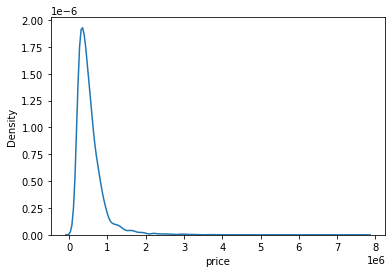

In [11]:
sns.kdeplot(sub_price)
plt.show()

In [12]:
sub_price = np.log1p(sub_price)
sub_price

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

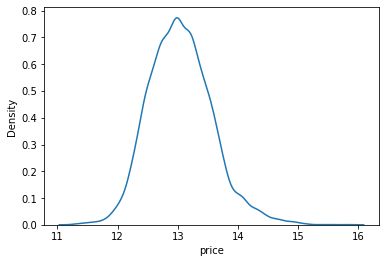

In [13]:
sns.kdeplot(sub_price)
plt.show()

+ train 각 데이터들의 분포 확인

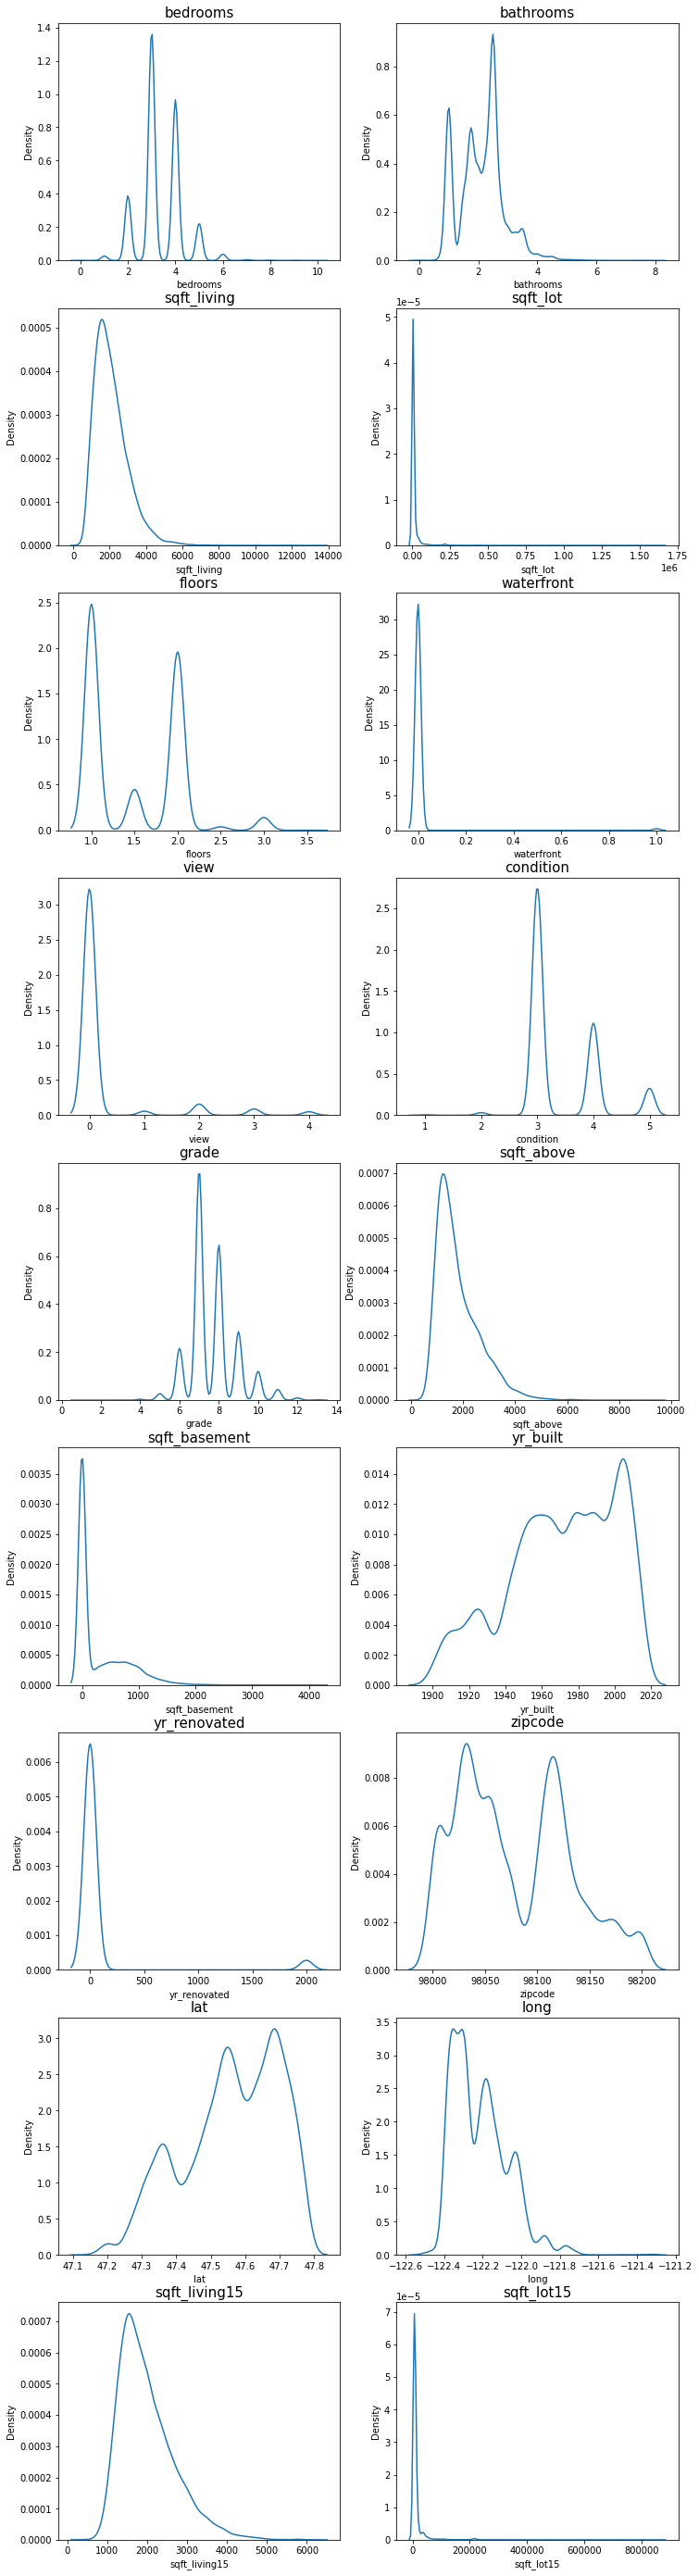

In [14]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))

# id는 앞서 제거하였고
# date 를 빼고 보기위해서 count = 1
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15' 'sqft_lot15', 가 한쪽으로 치우친 경향을 보였습니다.
log-scaling을 통해 데이터 분포를 정규화

In [15]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 
                'sqft_basement', 'sqft_living15', 'sqft_lot15']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

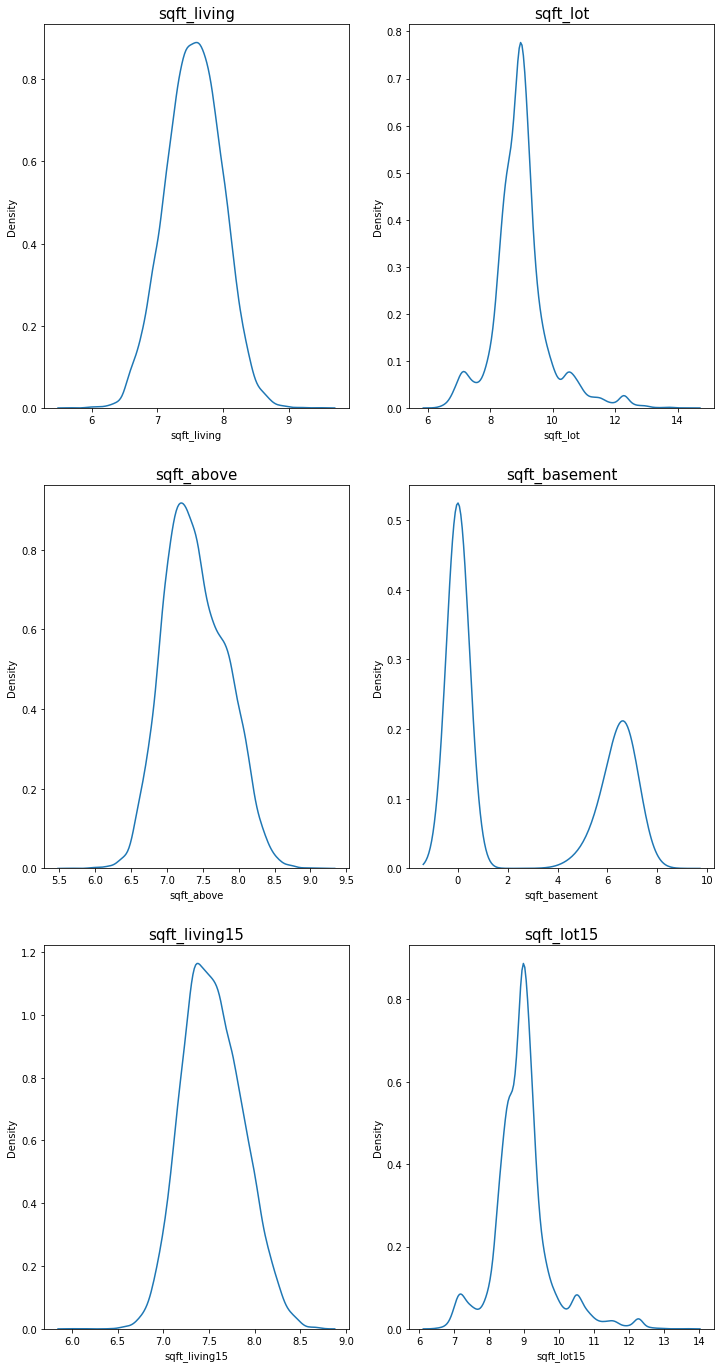

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(12, 24))

count = 0
for row in range(3):
    for col in range(2):
        if count == 6:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [17]:
print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


In [18]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


In [19]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,7.433075,8.941153
1,201412,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,7.215975,8.517393
2,201405,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,8.468213,11.532051
3,201504,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,7.484930,9.001346
4,201503,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,7.779467,8.932080


# 4.모델링

+ RMSE 계산

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [21]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 네 가지 모델

In [22]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [23]:
random_state=2021        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [24]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df
y_pred = get_scores(models, train, sub_price)

+ Grid Serch

In [25]:
from sklearn.model_selection import GridSearchCV

In [26]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [27]:
param_grid = {
    'n_estimators': [20000],
    'max_depth': [10],
    'num_leaves': [20],
    'learning_rate': [0.01,0.05]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, sub_price, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   7 out of  10 | elapsed:  3.9min remaining:  1.7min
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  4.0min finished


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
0,0.01,10,20000,20,-0.026452,0.162641
1,0.05,10,20000,20,-0.027537,0.165944


In [28]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    print(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [29]:
model = LGBMRegressor(learning_rate = 0.01, max_depth=10, 
                      n_estimators=20000, num_leaves=20, random_state=random_state)

In [30]:
save_submission(model, train, sub_price, test, 'lgbm', rmsle='0.1626')

[ 542488.44408354  483032.55437271 1217058.2205825  ...  473756.18648067
  328490.46191976  432117.15318177]
/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.1626.csv saved!


In [31]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data/'
submission_path = join(data_dir, 'submission_lgbm_RMSLE_0.1606.csv')
submission = pd.read_csv(submission_path)
submission.head(5)

,id,price
0,15035,4.987774e+05
1,15036,4.754889e+05
2,15037,1.380315e+06
3,15038,3.123854e+05
4,15039,3.305570e+05


---
# 회고

1. 필요없는 데이터는 삭제를 하고 한쪽으로 치우치는 경향이 있는 데이터는 log-scaling을 통해 데이터 분포를 정규화해주는 데이터 전처리를 하였다.   
속도가 나쁘지 않고 좋은 score를 얻은 LGBM모델을 선택하여 학습하여 예측값까지 잘 추출이 되었다.

2. 데이터의 분포도는 sns.kdeplot그래프를 이용해서 시각화를 하였고,
외에는 전처리,학습과정은 pandas를 이용해서 시각화를 하였다.

3. 학습 트리의 개수 n_estimators, 하나의 트리에서 가질수 있는 최대 리프의 개수 num_leaves, 트리의 최대깊이 max_depth, 학습률 learning_rate 네가지의 파라미터를 가지고 진행을 하고 있었고   
Private Score의 최적화 진행과정 중 정교한 결과를 위해, 마지막 순간에 더욱 좋은 결과를 도출하기 위해 영혼까지 끌어모으고 싶다면, learning_rate는 낮추고 num_estimators는 크게 하여 최상의 결과를 낼 수 있다고 찾게 되어서 learning_rate와 num_estimators의 값을 극대화 하였고 110000점 아래의 스코어가 나왔다.



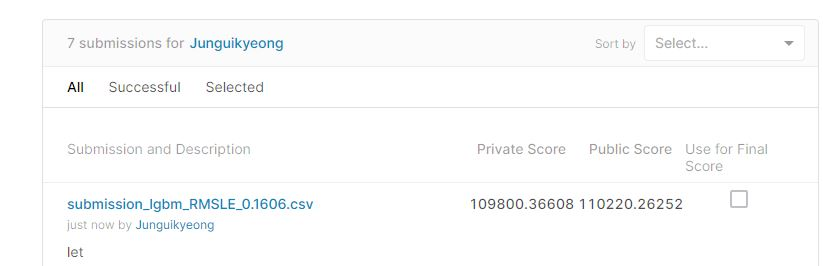